## **Stacking & Blending**
Среди всех методов ансамблирования особое внимание заслуживают две очень мощные техники, известные как *стекинг* (stacked generalization) и *блендинг*, особенность которых заключается в возможности использования прогнозов не только однородных, но и сразу нескольких разных по природе алгоритмов в качестве обучающих данных для другой модели, на которой будет сделан итоговый прогноз. Например, прогнозы логистической регрессии и градиентного бустинга могут быть использованы для обучения случайного леса, на котором уже будет выполнен итоговый прогноз.

Стекинг и блендинг очень схожи между собой, однако между ними есть существенные различия, заключающиеся в разделении и использовании тренировочных данных. Рассмотрим более подробно как это происходит.

### **Stacking**
Изначально датасет разбивается на тренировочный и тестовый. Далее с помощью k-fold кросс-валидации тренировочный датасет разбивается на k фолдов. Базовая модель обучается на k-1 фолдах и делает прогноз на оставшемся. Данная процедура повторяется для каждого фолда и в итоге получится вектор, состоящий из k-fold прогнозов и используемый как новый признак. Предыдущие шаги повторяются для каждой базовой модели и в итоге получится набор признаков, состоящий из прогнозов базовых моделей, к которым добавляется таргет *y_train* из исходного тренировочного датасета и полученный датасет будет новым тренировочным. Помимо этого, базовые модели также обучаются на всём исходном тренировочном множестве, после чего делается прогноз на тестовом датасете и в итоге получится новый тестовый набор.

На полученных датасетах (метаданных) обучается метамодель и производится итоговый прогноз.

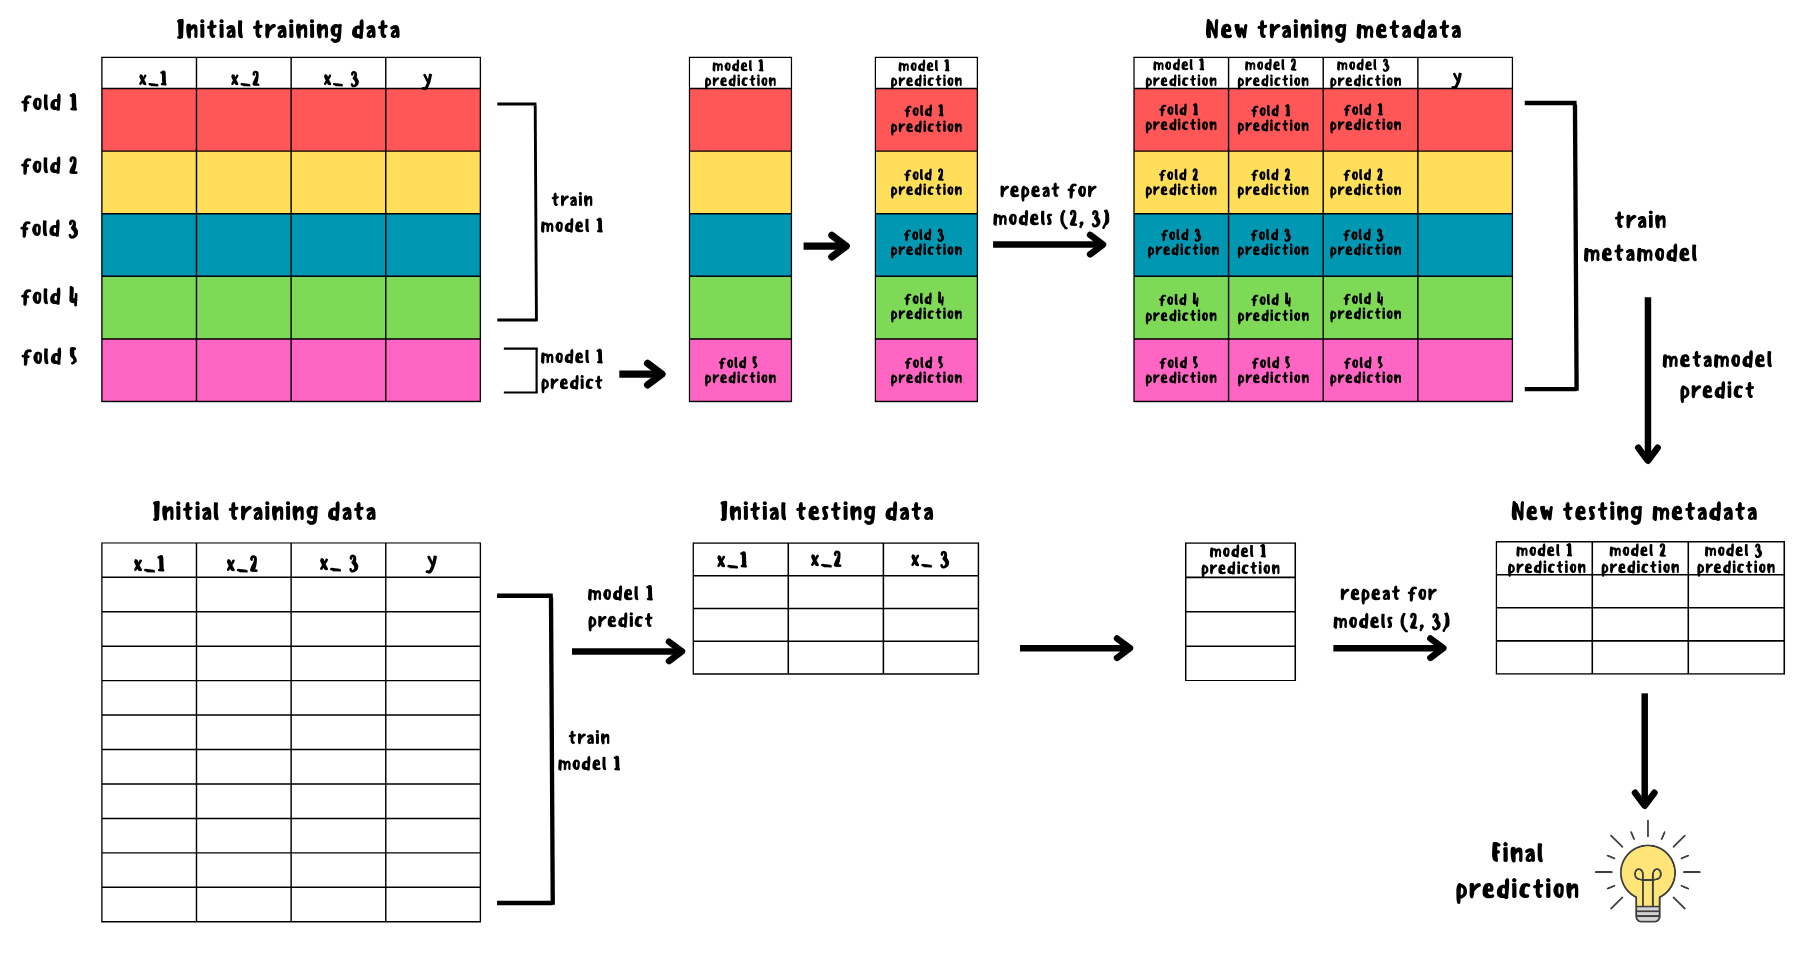

### **Blending**
Блендинг является более простой версией стекинга. Тренировочные данные разделяются на 2 части: также на тренировочную и валидационную с помощью hold-out кросс-валидации. Базовая модель обучается на тренировочных данных и делает прогноз как на валидационном, так и на тестовом наборе. Далее предыдущий шаг повторяется для каждой базовой модели: к прогнозам на валидационном наборе добавляется таргет *y_val* и полученный датасет используется в качестве тренировочного, а прогнозы на тестовом наборе используются в качестве нового тестового.

На полученных датасетах (метаданных) обучается метамодель и производится итоговый прогноз.

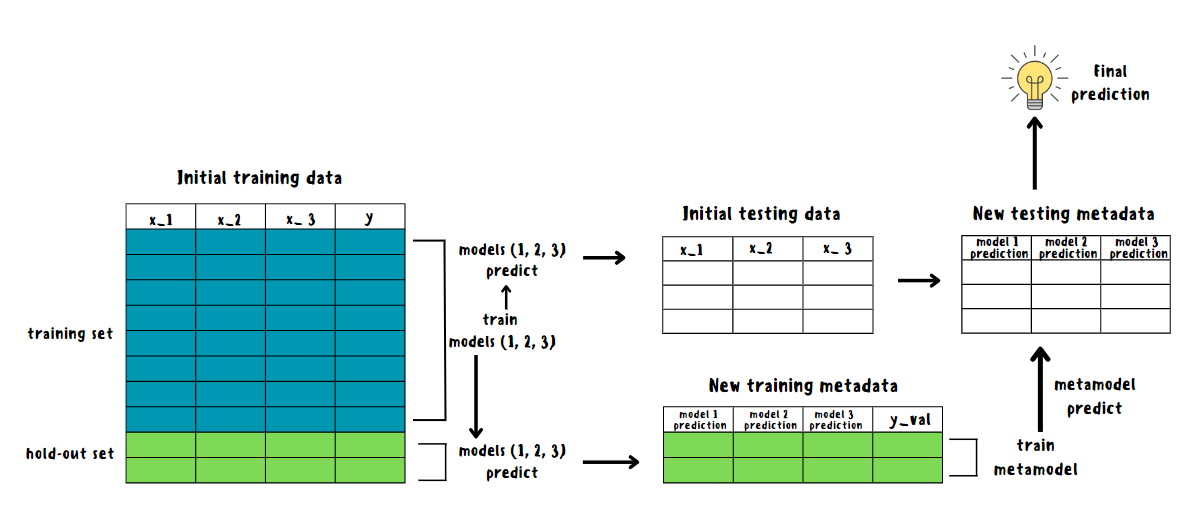

### **Более продвинутые техники**
Для ускорения работы стекинга и блендинга на практике используется **параллелизация во время обучения**, то есть каждая базовая модель может обучаться на разных ядрах параллельно. Нетрудно догадаться, что такой подход является особенно полезным при работе с большими наборами данных или сложными моделями. В реализации scikit-learn параллелизация реализована с помощью библиотеки *joblib*, а количество используемых ядер устанавливается с помощью параметра *n_jobs* (при значении -1 используются все доступные ядра). В ручной реализации ниже также применяется параллельное обучение.

Ещё стоит добавить, что существуют и другие версии стекинга и блендинга, например, когда новые метаданные добавляются к исходным. Помимо этого, стекинг и блендинг могут быть **многослойными**, когда на каждом уровне объединяются прогнозы моделей, полученные на предыдущем, а затем эти объединённые прогнозы используются для обучения новых моделей на следующем уровне. Иногда такой подход может дать неплохой прирост в плане точности, но стоит иметь в виду, что в таком случае время обучения также заметно увеличится.


На данный момент в scikit-learn реализована поддержка напрямую лишь для стекинга, однако, если выбрать 1 фолд для кросс-валидации и обучить базовые модели отдельно, то можно отдалённо получить что-то похожее на блендинг.

### **Реализация на Python с нуля**



In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from joblib import Parallel, delayed
from mlxtend.plotting import plot_decision_regions

In [21]:
class Stacking:
    def __init__(self, estimators, final_estimator, blending=False, cv=5, n_jobs=-1):
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.blending = blending
        self.cv = cv
        self.n_jobs = n_jobs

    def _X_pred(self, estimator, data):
        if self.blending:
            X_train_v, y_train_v, X_val = data
            return estimator.fit(X_train_v, y_train_v).predict(X_val)
        else:
            X_train, y_train = data
            return cross_val_predict(estimator, X_train, y_train, cv=self.cv)

    def _X_test_pred(self, estimator, data):
        X_train, y_train, X_test = data

        return estimator.fit(X_train, y_train).predict(X_test)

    def _meta_data(self, X_train, y_train, X_test):
        if self.blending:
            #used hold-out cross-validation
            X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, random_state=0)
            train_data = [X_train_v, y_train_v, X_val]
            test_data = [X_train_v, y_train_v, X_test]
            meta_y_train = y_val
        else:
            train_data = [X_train, y_train]
            test_data = [X_train, y_train, X_test]
            meta_y_train = y_train

        cv_X_train_preds = (delayed(self._X_pred)(est, train_data) for est in self.estimators)
        X_test_preds = (delayed(self._X_test_pred)(est, test_data) for est in self.estimators)

        meta_X_train = pd.DataFrame(Parallel(n_jobs=self.n_jobs)(cv_X_train_preds))
        meta_X_test = pd.DataFrame(Parallel(n_jobs=self.n_jobs)(X_test_preds))

        return meta_X_train.T, meta_y_train, meta_X_test.T

    def fit_predict(self, X_train, y_train, X_test):
        # meta learner or blender
        meta_X_train, meta_y_train, meta_X_test = self._meta_data(X_train, y_train, X_test)

        return self.final_estimator.fit(meta_X_train, meta_y_train).predict(meta_X_test)

In [22]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train.values[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train.values)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

### **Загрузка датасетов**
Для обучения моделей будет использован [Glass Classification](https://www.kaggle.com/datasets/uciml/glass) датасет, где необходимо верно определить тип стекла по его признакам. В случае регрессии используется Diabetes датасет из scikit-learn.

In [23]:
df_path = "/content/drive/MyDrive/glass.csv"
glass_df = pd.read_csv(df_path)
X1, y1 = glass_df.iloc[:, :-1], glass_df.iloc[:, -1]
y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=0)
print(glass_df)

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0     1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0     1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0     1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0     1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0     1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...   ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0     7
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0     7
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0     7
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0     7
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0     7

[214 rows x 10 columns]


In [24]:
X2, y2 = load_diabetes(return_X_y=True, as_frame=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0)
print(X2, y2, sep='\n')

          age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  
0   -0.002592  0.019907 -0.017646  
1  

### **Обучение моделей и оценка полученных результатов**
Как в случае классификации, так и регрессии, стекинг и блендинг показали одинаковые и не самые лучшие результаты. Как правило, такая ситуация происходит по двум причинам: учитывая, что метаданные строятся на прогнозах базовых моделей, то наличие слабых базовых моделей может снизить точность более сильных, что снизит итоговый прогноз в целом; также небольшое количество тренировочных данных часто приводит к переобучению, что в свою очередь снижает точность прогнозов.

В данном случае проблему можно частично решить, установив stack_method='predict_proba', когда каждый базовый классификатор выдаёт вероятности принадлежности к классам вместо самих классов, что может помочь увеличить точность в случае с не взаимоисключающими классами; также такой метод лучше работает с шумом в данных. Как можно заметить, данный способ позволил существенно увеличить точность модели. При правильном подборе моделей и гиперпараметров точность будет ещё выше.

Чаще всего стекинг показывает немного лучшие результаты чем блендинг из-за применения k-fold кросс-валидации, но обычно разница заметна лишь на большом количестве данных.

**StackingClassifier & BlendingClassifier**



In [25]:
estimators = [LogisticRegression(random_state=0, max_iter=10000),
              GradientBoostingClassifier(random_state=0),
              SVC(probability=True, random_state=0)]

estimator = RandomForestClassifier(random_state=0)
stacking_clf = Stacking(estimators=estimators, final_estimator=estimator)
stacking_pred_res = stacking_clf.fit_predict(X1_train, y1_train, X1_test)
stacking_accuracy = accuracy_score(y1_test, stacking_pred_res)
print(f'stacking_accuracy: {stacking_accuracy}')
print(stacking_pred_res, '', sep='\n')

blending_clf = Stacking(estimators=estimators, final_estimator=estimator, blending=True)
blending_pred_res = blending_clf.fit_predict(X1_train, y1_train, X1_test)
blending_accuracy = accuracy_score(y1_test, blending_pred_res)
print(f'blending_accuracy: {blending_accuracy}')
print(blending_pred_res)

stacking_accuracy: 0.6481481481481481
[5 0 1 4 1 1 0 1 1 1 1 0 1 1 1 5 0 1 0 0 3 0 5 5 0 0 5 0 0 1 0 0 1 0 1 0 0
 0 0 5 3 4 1 0 1 1 0 1 0 1 0 4 5 0]

blending_accuracy: 0.6481481481481481
[5 0 1 4 1 1 0 1 1 1 1 0 1 1 1 5 0 1 0 1 5 1 5 5 1 0 5 0 1 1 0 0 1 0 0 0 0
 0 0 5 3 5 1 0 1 1 0 1 0 1 0 4 5 0]


**StackingClassifier (scikit-learn)**

sk_stacking_accuracy with a predict method: 0.6481481481481481
[5 0 1 4 1 1 0 1 1 1 1 0 1 1 1 5 0 1 0 0 3 0 5 5 0 0 5 0 0 1 0 0 1 0 1 0 0
 0 0 5 3 4 1 0 1 1 0 1 0 1 0 4 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


sk_stacking_accuracy with a predict_proba method: 0.7592592592592593
[5 0 1 4 3 1 0 1 1 1 1 0 1 1 1 5 0 1 2 2 3 0 5 5 1 0 5 0 1 1 0 0 1 0 1 0 0
 2 0 5 5 4 1 0 1 1 0 1 0 1 0 4 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


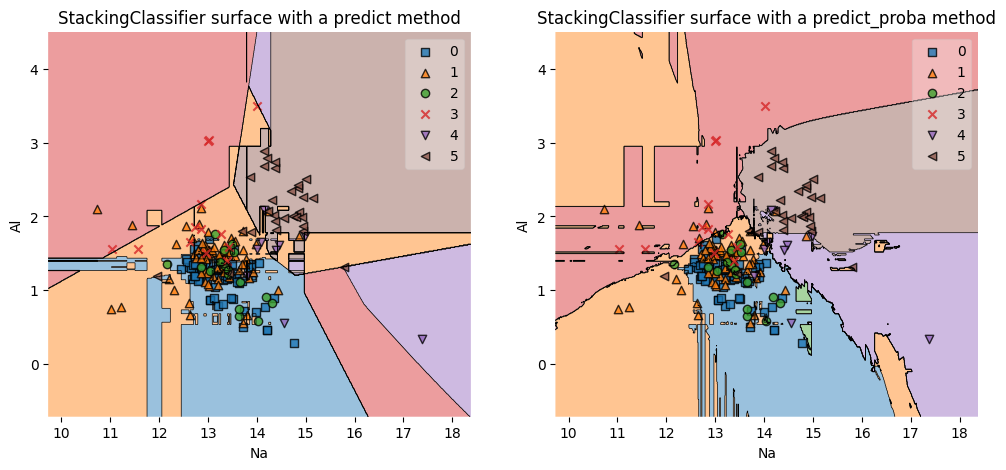

In [26]:
sk_estimators = [('lr', LogisticRegression(random_state=0, max_iter=10000)),
                 ('gbc', GradientBoostingClassifier(random_state=0)),
                 ('svc', SVC(probability=True, random_state=0))]

stack_methods = ('predict', 'predict_proba')
estimator = RandomForestClassifier(random_state=0)
sk_stacking_clf = StackingClassifier(estimators=sk_estimators, final_estimator=estimator)

feature_indexes = [1, 3]
plt.figure(figsize=(12, 5))

for i, method in enumerate(stack_methods):
    sk_stacking_clf.stack_method = method
    sk_stacking_clf.fit(X1_train, y1_train)
    sk_stacking_pred_res = sk_stacking_clf.predict(X1_test)
    sk_stacking_accuracy = accuracy_score(y1_test, sk_stacking_pred_res)
    print(f'sk_stacking_accuracy with a {method} method: {sk_stacking_accuracy}')
    print(sk_stacking_pred_res)

    plt.subplot(1, 2, i + 1)
    plt.subplots_adjust(hspace=1.5)
    title = f'StackingClassifier surface with a {method} method'
    decision_boundary_plot(X1, y1, X1_train, y1_train, sk_stacking_clf, feature_indexes, title)

**StackingRegressor & StackingRegressor (scikit-learn)**

In [27]:
reg_estimators = [RandomForestRegressor(random_state=0),
                  GradientBoostingRegressor(random_state=0)]

stacking_reg = Stacking(estimators=reg_estimators, final_estimator=RidgeCV())
stacking_reg_pred_res = stacking_reg.fit_predict(X2_train, y2_train, X2_test)
stacking_mape = mean_absolute_percentage_error(y2_test, stacking_reg_pred_res)
print(f'stacking_regressor_mape {stacking_mape}')
print(stacking_reg_pred_res, '', sep='\n')

sk_reg_estimators = [('rfr', RandomForestRegressor(random_state=0)),
                     ('gbr', GradientBoostingRegressor(random_state=0))]

sk_stacking_reg = StackingRegressor(estimators=sk_reg_estimators)
sk_stacking_reg.fit(X2_train, y2_train)
sk_stacking_reg_pred_res = sk_stacking_reg.predict(X2_test)
sk_stacking_mape = mean_absolute_percentage_error(y2_test, sk_stacking_reg_pred_res)
print(f'sk_stacking_regressor_mape {sk_stacking_mape}')
print(sk_stacking_reg_pred_res)

stacking_regressor_mape 0.39979248717477694
[248.19759057 240.42764024 177.37191492 103.86233455 200.13250024
 250.97352765  96.82048975 220.71264013 131.5200259  236.41159677
 175.71519802 160.35569454 130.9100711   93.65232358 282.06237765
  99.93621948 161.47206754  78.65895059 108.86806694 224.46260151
 182.68564834 127.54111953 163.28785267 138.89063619 220.53939703
 189.84079506 136.98136758  78.91556812 219.66245835 159.14526636
 198.39205847  82.77579781 117.59833274 157.49622357 139.53979064
 171.05953707 152.42297469 135.62774138  94.81503188 213.49660018
 110.36059875 162.00479518 132.07261264 178.57636808 179.29614901
  73.3945309  114.601665   131.93470279 100.32309962 252.57462411
 146.00870076  61.92053404 170.56742259 157.92964414 243.28628037
 205.27588938 180.79716523 114.89480581 120.80464762 172.87785542
 243.4033502  151.64437003 130.09006375 100.99049563 249.91693845
 153.00241663  87.45729779 230.20145421 215.78130712  90.82440238
  88.24276622 143.91478174 110.8

### **Преимущества и недостатки стекинга и блендинга**
Преимущества:
- значительное улучшение точности прогнозов при правильном использовании.

Недостатки:
- высокие вычислительные затраты;
- возможность переобучения из-за трудностей в правильном подборе и настройке базовых моделей, а также сложность в интерпретации.

### **Дополнительные источники**
Статья «An Interpretation of Stacking and Blending Approach in Machine
Learning», Divya Khyani, Soumya Jakkula, Sanjana Gowda N C, Anusha K J, Swetha K R.

Документация:
- [описание стекинга](https://scikit-learn.org/stable/modules/ensemble.html#stacking);
- [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html);
- [StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html).

Видео: [один](https://www.youtube.com/watch?v=xtTyEoJ31Vg&ab_channel=UnfoldDataScience), [два](https://www.youtube.com/watch?v=TuIgtitqJho).